#verify pyEMU results with the henry problem

In [1]:
%pylab inline
import os
import numpy as np
import pylab as ply
import pandas as pd
import pyemu
import pst_handler as phand
import mat_handler as mhand

Populating the interactive namespace from numpy and matplotlib


instaniate ```pyemu``` object and drop prior info.  Then reorder the jacobian and save as binary.  This is needed because the pest utilities require strict order between the control file and jacobian

In [2]:
la = pyemu.schur("pest.jco",verbose=False)
la.drop_prior_information()
jco_ord = la.jco.get(la.pst.obs_names,la.pst.par_names)
ord_base = "pest_ord"
jco_ord.to_binary(ord_base + ".jco")  

extract and save the forecast sensitivity vectors

In [3]:
pv_names = []
predictions =  ["pd_ten", "c_obs10_2"]
for pred in predictions:
    pv = jco_ord.extract(pred).T
    pv_name = pred + ".vec"
    pv.to_ascii(pv_name)
    pv_names.append(pv_name)
    

save the prior parameter covariance matrix as an uncertainty file

In [4]:
prior_uncfile = "pest.unc"
la.parcov.to_uncfile(prior_uncfile,covmat_file=None)

#PRECUNC7
write a response file to feed ```stdin``` to ```predunc7```

In [5]:
post_mat = "post.cov"
post_unc = "post.unc"
args = [ord_base + ".pst","1.0",prior_uncfile,
        post_mat,post_unc,"1"]
pd7_in = "predunc7.in"
f = open(pd7_in,'w')
f.write('\n'.join(args)+'\n')
f.close()
out = "pd7.out"
pd7 = os.path.join("exe","i64predunc7.exe")
os.system(pd7 + " <" + pd7_in + " >"+out)
for line in open(out).readlines():
    print line,


 PREDUNC7 Version 13.3. Watermark Numerical Computing.

 Enter name of PEST control file:  Enter observation reference variance: 
 Enter name of prior parameter uncertainty file: 
 Enter name for posterior parameter covariance matrix file:  Enter name for posterior parameter uncertainty file: 
 Use which version of linear predictive uncertainty equation:-
     if version optimized for small number of parameters   - enter 1
     if version optimized for small number of observations - enter 2
 Enter your choice: 
 - reading PEST control file pest_ord.pst....
 - file pest_ord.pst read ok.

 - reading Jacobian matrix file pest_ord.jco....
 - file pest_ord.jco read ok.

 - reading parameter uncertainty file pest.unc....
 - parameter uncertainty file pest.unc read ok.
 - forming XtC-1(e)X matrix....
 - inverting prior C(p) matrix....
 - inverting [XtC-1(e)X + C-1(p)] matrix....
 - writing file post.cov...
 - file post.cov written ok.
 - writing file post.unc...
 - file post.unc written ok.


load the posterior matrix written by ```predunc7```

In [6]:
post_pd7 = mhand.cov()
post_pd7.from_ascii(post_mat)

la_ord = pyemu.schur(jco="pest_ord.jco",predictions=predictions)
post_pyemu = la_ord.posterior_parameter
#post_pyemu = post_pyemu.get(post_pd7.row_names)

The cumulative difference between the two posterior matrices:

In [7]:
delta = (post_pd7 - post_pyemu).x
(post_pd7 - post_pyemu).to_ascii("delta.cov")
print delta.sum()
print delta.max(),delta.min()

1.70407837082e-06
4.97750649586e-08 -4.98772445567e-08


#PREDUNC1
write a response file to feed ```stdin```.  Then run ```predunc1``` for each forecast

In [8]:
args = [ord_base + ".pst", "1.0", prior_uncfile, None, "1"]
pd1_in = "predunc1.in"
pd1 = os.path.join("exe", "i64predunc1.exe")
pd1_results = {}
for pv_name in pv_names:
    args[3] = pv_name
    f = open(pd1_in, 'w')
    f.write('\n'.join(args) + '\n')
    f.close()
    out = "predunc1" + pv_name + ".out"
    os.system(pd1 + " <" + pd1_in + ">" + out)
    f = open(out,'r')
    for line in f:
        if "pre-cal " in line.lower():
            pre_cal = float(line.strip().split()[-2])
        elif "post-cal " in line.lower():
            post_cal = float(line.strip().split()[-2])
    f.close()        
    pd1_results[pv_name.split('.')[0].lower()] = [pre_cal, post_cal]  
   
  

organize the ```pyemu``` results into a structure for comparison

In [9]:
pyemu_results = {}
for pname in la_ord.prior_prediction.keys():
    pyemu_results[pname] = [np.sqrt(la_ord.prior_prediction[pname]),
                            np.sqrt(la_ord.posterior_prediction[pname])]

compare the results:

In [10]:
f = open("predunc1_textable.dat",'w')
for pname in pd1_results.keys():
    print pname
    f.write(pname+"&{0:6.5f}&{1:6.5}&{2:6.5f}&{3:6.5f}\\\n"\
            .format(pd1_results[pname][0],pyemu_results[pname][0],
                    pd1_results[pname][1],pyemu_results[pname][1]))
    print "prior",pname,pd1_results[pname][0],pyemu_results[pname][0]
    print "post",pname,pd1_results[pname][1],pyemu_results[pname][1]
f.close()

c_obs10_2
prior c_obs10_2 0.1509421 0.150942104963
post c_obs10_2 0.089084382 0.0890843823278
pd_ten
prior pd_ten 0.4716172 0.471617160877
post pd_ten 0.2267402 0.226740171374


##PREDVAR1b
write the nessecary files to run ```predvar1b```

In [11]:
f = open("pred_list.dat",'w')
out_files = []
for pv in pv_names:
    out_name = pv+".predvar1b.out"
    out_files.append(out_name)
    f.write(pv+" "+out_name+"\n")
f.close()
args = ["pest_ord.pst","1.0","pest.unc","pred_list.dat"]
for i in xrange(36):
    args.append(str(i))
args.append('')    
args.append("n")
args.append("y")
f = open("predvar1b.in", 'w')
f.write('\n'.join(args) + '\n')
f.close()

os.system("predvar1b.exe <predvar1b.in")


0

In [12]:
pv1b_results = {}
for out_file in out_files:
    pred_name = out_file.split('.')[0]
    f = open(out_file,'r')
    for _ in xrange(3):
        f.readline()
    arr = np.loadtxt(f)
    pv1b_results[pred_name] = arr


now for pyemu

In [13]:
la_ord_errvar = pyemu.errvar(jco="pest_ord.jco",
                             predictions=predictions,
                             omitted_parameters="mult1",
                             verbose=False)
df = la_ord_errvar.get_errvar_dataframe(np.arange(36))
df

first                  second                       third          
    c_obs10_2    pd_ten     c_obs10_2           pd_ten  c_obs10_2    pd_ten
0    0.015706  0.076700  0.000000e+00         0.000000   0.007078  0.145723
1    0.006040  0.046811  8.323523e-04         0.002574   0.115553  0.132455
2    0.005905  0.045945  9.201068e-04         0.003138   0.077244  0.271644
3    0.004850  0.042798  4.135876e-03         0.012732   0.029392  0.497192
4    0.004582  0.037457  5.612732e-03         0.042138   0.034111  0.417314
5    0.004233  0.031039  8.756785e-03         0.099968   0.041801  0.534001
6    0.004156  0.031010  9.697704e-03         0.100323   0.038039  0.525583
7    0.004155  0.030849  9.728439e-03         0.103224   0.038043  0.525723
8    0.004084  0.029342  1.123436e-02         0.135497   0.041175  0.579882
9    0.004084  0.029109  1.123444e-02         0.142235   0.041173  0.581877
10   0.004084  0.028689  1.124962e-02         0.154709   0.041273  0.571117
11   0.004083  0.027723  1.127209e-02         0.187055   0.041139  0.552224
12   0.004044  0.027693  1.373466e-02         0.188909   0.041676  0.553927
13   0.003870  0.027380  2.509977e-02         0.209444   0.038285  0.571023
14   0.003397  0.023741  5.647082e-02         0.450806   0.029120  0.680726
15   0.003397  0.023106  5.648180e-02         0.497374   0.029097  0.687914
16   0.003397  0.022881  5.654890e-02         0.517650   0.029181  0.695037
17   0.003395  0.022858  5.673687e-02         0.520294   0.029307  0.692737
18   0.003021  0.022763  1.240355e-01         0.537373   0.029080  0.692178
19   0.002723  0.022762  3.052508e+00         0.549347   0.031426  0.692896
20   0.002716  0.022580  4.771325e+01      1123.392160   0.025201  0.856170
21   0.002714  0.022526  6.754794e+01      1881.534060   0.025839  0.833455
22   0.002700  0.022522  3.533209e+02      1958.512210   0.021420  0.819873
23   0.002695  0.022522  5.097773e+02      1959.861780   0.020532  0.820389
24   0.002693  0.022217  6.125413e+02     17710.973817   0.019521  0.902417
25   0.002685  0.014189  2.167707e+03   1588459.611546   0.021336  0.559757
26   0.002672  0.013960  4.329741e+05   9693313.787926   0.023606  0.610004
27   0.002671  0.013957  4.330029e+05   9752749.190099   0.023531  0.605561
28   0.002655  0.013950  2.225640e+06  10525907.014839   0.019299  0.631240
29   0.002655  0.013911  2.311274e+06  12667239.969311   0.016324  0.611357
30   0.002655  0.013911  2.311274e+06  12667239.969311   0.016324  0.611357
31   0.002651  0.013903  3.099684e+06  13941242.071887   0.012888  0.558635
32   0.002651  0.013903  3.099684e+06  13941242.071887   0.012888  0.558635
33   0.002649  0.013903  5.724124e+05  12810429.385802   0.020263  0.616900
34   0.002640  0.013902  1.575821e+07  17047148.952689   0.022975  0.589226
35   0.002601  0.013800  1.125029e+08  77313263.704106   0.020572  0.542208

generate some plots to verify

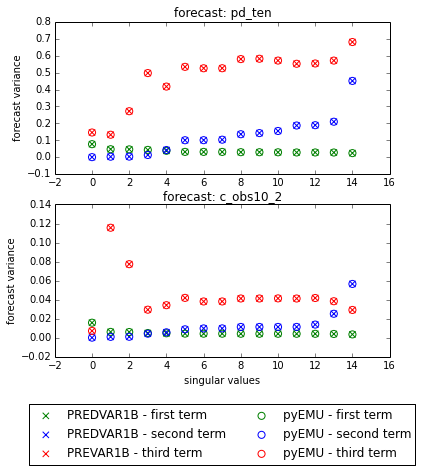

In [14]:
fig = plt.figure(figsize=(6,6))
max_idx = 15
idx = np.arange(max_idx)
for ipred,pred in enumerate(predictions):
    arr = pv1b_results[pred][:max_idx,:]
    first = df[("first", pred)][:max_idx]
    second = df[("second", pred)][:max_idx]
    third = df[("third", pred)][:max_idx]
    ax = plt.subplot(len(predictions),1,ipred+1)
    #ax.plot(arr[:,1],color='b',dashes=(6,6),lw=4,alpha=0.5)
    #ax.plot(first,color='b')
    #ax.plot(arr[:,2],color='g',dashes=(6,4),lw=4,alpha=0.5)
    #ax.plot(second,color='g')
    #ax.plot(arr[:,3],color='r',dashes=(6,4),lw=4,alpha=0.5)
    #ax.plot(third,color='r')
    
    ax.scatter(idx,arr[:,1],marker='x',s=40,color='g',
               label="PREDVAR1B - first term")
    ax.scatter(idx,arr[:,2],marker='x',s=40,color='b',
               label="PREDVAR1B - second term")
    ax.scatter(idx,arr[:,3],marker='x',s=40,color='r',
               label="PREVAR1B - third term")
    ax.scatter(idx,first,marker='o',facecolor='none',
               s=50,color='g',label='pyEMU - first term')
   
    ax.scatter(idx,second,marker='o',facecolor='none',
               s=50,color='b',label="pyEMU - second term")
    
    ax.scatter(idx,third,marker='o',facecolor='none',
               s=50,color='r',label="pyEMU - third term")
    ax.set_ylabel("forecast variance")
    ax.set_title("forecast: " + pred)
    if ipred == len(predictions) -1:
        ax.legend(loc="lower center",bbox_to_anchor=(0.5,-0.75),
                  scatterpoints=1,ncol=2)
        ax.set_xlabel("singular values")
    #break
plt.savefig("predvar1b_ver.eps")    
    

#Identifiability

In [18]:
cmd_args = [os.path.join("exe","i64identpar.exe"),"pest_ord","5",
            "null","null","ident.out","/s"]
cmd_line = ' '.join(cmd_args)+'\n'
print(cmd_line)
print(os.getcwd())
os.system(cmd_line)

exe\i64identpar.exe pest_ord 5 null null ident.out /s

D:\Users\jwhite\git_repo\pyemu\verification\henry


0

In [19]:
identpar_df = pd.read_csv("ident.out",delim_whitespace=True)

In [20]:
la_ord_errvar = pyemu.errvar(jco="pest_ord.jco",
                             predictions=predictions,
                             verbose=False)
df = la_ord_errvar.get_identifiability_dataframe(5)
df

,right_sing_vec_1,right_sing_vec_2,right_sing_vec_3,right_sing_vec_4,right_sing_vec_5,ident
mult1,9.907986e-01,4.284511e-03,6.814463e-04,3.047248e-05,6.673591e-05,9.958617e-01
kr01c01,0.000000e+00,9.984021e-31,1.642125e-29,2.330375e-30,6.952607e-32,1.981955e-29
kr01c02,0.000000e+00,0.000000e+00,1.109336e-31,1.676041e-31,2.204997e-30,2.483535e-30
kr01c03,0.000000e+00,0.000000e+00,1.232595e-32,6.312356e-31,2.491973e-30,3.135534e-30
kr01c04,6.831969e-134,0.000000e+00,4.814825e-35,1.972152e-31,1.109336e-31,3.081969e-31
kr01c05,6.634155e-134,0.000000e+00,0.000000e+00,0.000000e+00,1.109336e-31,1.109336e-31
kr01c06,6.885196e-98,0.000000e+00,0.000000e+00,0.000000e+00,1.232595e-32,1.232595e-32
kr01c07,6.885196e-98,0.000000e+00,0.000000e+00,0.000000e+00,7.703720e-34,7.703720e-34
kr01c08,4.650818e-77,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.650818e-77
kr01c09,4.650818e-77,2.672152e-76,0.000000e+00,0.000000e+00,0.000000e+00,3.137234e-76


cheap plot to verify

[ -1.98083853e-008  -1.88378760e-029  -1.91235766e-030  -3.13408376e-030
  -7.27576194e-032  -1.48437508e-032  -1.20085605e-032  -7.70371978e-034
  -4.65081773e-077  -3.13723377e-076  -4.06621562e-059  -2.76351489e-059
  -2.80947414e-059  -1.87403020e-058  -1.96797403e-058  -7.36843693e-057
  -1.01807611e-017  -1.01807611e-017  -1.11465896e-017   3.83062052e-017
   2.81717169e-017   5.03805436e-018  -1.87743830e-016  -3.93717021e-016
  -1.80434265e-015   3.71073636e-015  -9.45466170e-016   4.95910876e-015
  -3.00086394e-014   2.84068199e-014   1.21218606e-014   3.75141328e-013
  -2.17963465e-013  -4.58095591e-013  -1.50713009e-012  -3.19770902e-013
   4.24658334e-011  -7.83163378e-012   4.78332695e-011  -2.60372357e-011
  -4.93031388e-011  -4.41308596e-011  -3.59513114e-011   3.88547233e-011
  -1.44349593e-011  -1.79195274e-011  -4.57275407e-012   1.80235184e-011
   2.33137216e-011  -3.01885583e-011   3.13851464e-010   2.94038799e-010
  -4.13507506e-010  -3.28327740e-010   3.44793943e-

(-1, 1)

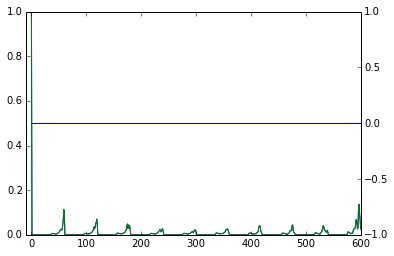

In [32]:
fig = plt.figure()
ax = plt.subplot(111)
axt = plt.twinx()
ax.plot(identpar_df["identifiability"])
ax.plot(df["ident"])
ax.set_xlim(-10,600)
diff = identpar_df["identifiability"].values - df["ident"].values
print(diff)
axt.plot(diff)
axt.set_ylim(-1,1)